In [7]:
import sys

from datetime import datetime

import pickle

import numpy as np

from scipy import signal
from scipy.io import wavfile
from scipy.ndimage import maximum_filter1d

import librosa
import librosa.display

import IPython.display as ipd
import matplotlib as mpl
import matplotlib.pyplot as plt

import noisereduce as nr
import sounddevice as sd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.neural_network import MLPClassifier as MLPC

In [8]:
experiment_words = {0: "Si", 1: "No", 2: "Agua", 3: "Comida", 4: "Dormir"}
experiments = ["S1","S2","S3","S4","S5","S6","S7","S8","S9","S10", "S11","S12","S13","S14","S15","S16","S17","S18","S19","S20","S21"]
start_times = [
               [1642014432149, 1642015279544, 1642018989749, 1642020887444],
               [1642709615609, 1642711231738, 1642711835204, 1642712508208],
               [1644518789205, 1644520973370, 1644522282435, 1644523772595],
               [1644862510935, 1644863357729, 1644865356405, 1644866623555],
               [1645482826638, 1645483436673, 1645484657373, 1645485205833],
               [1645554802796, 1645555630886, 1645556859926, 1645558841261],
               [1648486056563, 1648487671163, 1648488386468, 1648490709339],
               [1649090396023, 1649091769558, 1649093282188, 1649094574062],
               [1649278404169, 1649279608174, 1649281024999, 1649282379874],
               [1650920673044, 1650923140274, 1650924725039, 1650926126008],
               [1651094440648, 1651096907818, 1651098189088, 1651098737278],
               [1656436998229, 1656439163269, 1656440705674, 1656441834469],
               [1656969103156, 1656970379056, 1656971629516, 1656973066382],
               [1657049040213, 1657049659382, 1657050893252, 1657052118783],
               [1657129933144, 1657132533843, 1657133919543, 1657134545374],
               [1657224812372, 1657226244392, 1657227424832, 1657228717592],
               [1658249751572, 1658251555338, 1658253050808, 1658254500602],
               [1658353326561, 1658355283357, 1658356772781, 1658357937487],
               [1658440699211, 1658442012506, 1658443246676, 1658444370311],
               [1658769696993, 1658772115023, 1658773323258, 1658773882233],
               [1658853510844, 1658854815019, 1658856377014, 1658857631179],
               ]

***
# **FUNCTIONS**

In [9]:
#Get the words identified by each code 
#and its start/finish time in ms from the .mrk file
def get_durations(marks_path, palabras={2: "Si", 3: "No", 4: "Agua", 5: "Comida", 6: "Dormir"}):
    durations = []

    with open(marks_path) as file:
        line_index = 0

        for line in file:
            marks = line[:line.rfind("\n")].split("\t")
            stage = int(marks[0])
            if stage != 1 and stage != 7:
                durations.append([stage, palabras.get(stage), int(marks[1]), 0])
            elif stage == 7:
                durations[line_index][-1] = int(marks[1])
                line_index += 1
    
    return durations

In [10]:
#Def for cutting words
#Cuts from the signal passed the left and right parts of it
#to_center = True, traverses the signal from the extremes to the center, stopping until the values found are >= max value of signal*percentage of each side
#to_center = False, traverses the signal from the center outwards, stopping until the values found are <= max value of the signal*percentage of each side
#If extra_ms_l/r is used, the cut word will get extra milliseconds before it starts or after it ends

#Returns the index where the cutting of the signal started and a slice of the original signal, cut from the moment a disruption in the intensity
#was found (depending on percentages given)

def word_cut(data, freq, palabra, per_left=0.1, per_right=0.1, to_center=True, extra_ms_l=0, extra_ms_r=0):
    ch0_o = data[palabra][2]
    ch0 = maximum_filter1d(abs(ch0_o), size=1000)
    max_abs_ch0 = np.argmax(ch0)

    start_ch0, end_ch0 = 0, 0

    if to_center:
        for i in range(len(ch0)):
            if abs(ch0[i]) >= ch0[max_abs_ch0]*per_left:
                start_ch0 = i
                break

        for j in range(len(ch0)-1, 0, -1):
            if abs(ch0[j]) >= ch0[max_abs_ch0]*per_right:
                end_ch0 = j
                break
    else:
        for i in range(max_abs_ch0, 0, -1):
            if abs(ch0[i]) <= ch0[max_abs_ch0]*per_left:
                start_ch0 = i
                break

        for j in range(max_abs_ch0, len(ch0)):
            if abs(ch0[j]) <= ch0[max_abs_ch0]*per_right:
                end_ch0 = j
                break

    extra_index = 0
    if extra_ms_l > 0:
        extra_index = int((extra_ms_l/1000.0)*freq)
        start_ch0 -= extra_index

        if start_ch0 < 0:
            start_ch0 = 0
    
    if extra_ms_r > 0:
        extra_index = int((extra_ms_r/1000.0)*freq)
        end_ch0 += extra_index

        if end_ch0 >= len(ch0_o):
            end_ch0 = len(ch0_o)-1

    word = np.array(ch0_o[start_ch0: end_ch0])
    return start_ch0, word

In [11]:
#Get a list of lists of the words and its intensity data
#Slices the data retrieved from the audio file
#depending on the start/end times of the words in the durations array
def get_word_stages(audio_data, fs, durations, start_time):
    word_stages = []

    for i in range(len(durations)):
        start_cut = ((durations[i][2] - start_time)//1000)*fs
        end_cut = ((durations[i][3] - start_time)//1000)*fs
        word_stages.append(durations[i][:-2])
        word_stages[i].append(audio_data[start_cut:end_cut])

    return word_stages

In [12]:
#Gives a list of lists which contains (each one) the cut words from all the wav files
#and the indexes of when the word started to be pronounced
def cut_all_words(data_dir, samples_array, all_samples=True, person_limit = 1, experiment_n=1):
    sample = "S" + str(experiment_n)
    limit = person_limit

    if not 1 <= experiment_n <= len(samples_array):
        sample = "S1"

    if all_samples and not 1 <= limit <= len(samples_array):
        limit = len(samples_array)
    elif not all_samples:
        limit = 1

    cut_all_words = []
    cutting_indexes = []
    min_len = sys.maxsize
    max_len = 0

    for person in range(1, limit+1):
        for wav in range(1, 5):
            audio_dir = data_dir
            marks_dir = data_dir
            
            if not all_samples:
                audio_dir += sample + "\\" + sample + "_" + str(wav) + ".wav"
                marks_dir += sample + "\\" + sample + "_HP_cruces" + str(wav) + ".mrk"
            else:
                audio_dir += "S" + str(person) + "\\" + "S" + str(person) + "_" + str(wav) + ".wav"
                marks_dir += "S" + str(person) + "\\" + "S" + str(person) + "_HP_cruces" + str(wav) + ".mrk"

            data, freq = librosa.load(audio_dir)
            durations = get_durations(marks_dir)

            if not all_samples:
                words = get_word_stages(data, freq, durations, start_times[experiment_n-1][wav-1])
            else:
                words = get_word_stages(data, freq, durations, start_times[person-1][wav-1])

            filtered_words = []
            for tr in range(len(words)):
                ff1 = nr.reduce_noise(words[tr][2], freq)
                filtered_words.append(words[tr][:-1])
                filtered_words[tr].append(ff1)

            cut_words = []
            current_cut_index = 0
            for palabra in range(len(filtered_words)):
                ind, cut_words_temp = word_cut(filtered_words, freq, palabra, per_right=0.01, to_center=False, extra_ms_r=100)
                
                if len(cut_words_temp) >= int(0.2*freq):
                    cutting_indexes.append(ind)
                    cut_words.append(filtered_words[palabra][:-1].copy())
                    cut_words[current_cut_index].append(cut_words_temp)
                    current_cut_index += 1
                    
                    if len(cut_words_temp) < min_len:
                        min_len = len(cut_words_temp)

                    if len(cut_words_temp) > max_len:
                        max_len = len(cut_words_temp)

            cut_all_words.append(cut_words)

    return cut_all_words, cutting_indexes, min_len, max_len

In [13]:
#Gives the list of the cut words but alligned to a fixed len, so all the words will have the same size (used for getting the same number of mffc features)
def get_alligned_words(cut_words, max_len):
    alligned_cut_words = cut_words

    for wav in range(len(alligned_cut_words)):
        for word in range(len(alligned_cut_words[wav])):
            temp_word = alligned_cut_words[wav][word][2].copy()
            
            if len(temp_word) > max_len:
                alligned_cut_words[wav][word][2] = temp_word[:max_len]
            else:
                lack_len = max_len-len(temp_word)
                expand = np.zeros(lack_len)
                alligned_cut_words[wav][word][2] = np.concatenate((temp_word, expand))

    return alligned_cut_words

In [14]:
#Get the mffc features of each of the cut words
#Returns a list of lists containing the features of each individual word
def get_words_mffc(cut_words_data, fr, put_targets=False):
    all_mffcs = []

    for record in range(len(cut_words_data)):
        for word in range(len(cut_words_data[record])):
            
            signal = cut_words_data[record][word][2]
            mffcs_features = librosa.feature.mfcc(signal, n_mfcc=13, sr=fr).flatten()
            if not put_targets:
                all_mffcs.append(mffcs_features)
            else:
                all_mffcs.append([cut_words_data[record][word][0], mffcs_features])
    
    return all_mffcs

In [15]:
def get_training_array(cut_words_data):
    training_array = []

    for record in range(len(cut_words_data)):
        for word in range(len(cut_words_data[record])):
            
            objective = cut_words_data[record][word][0]
            training_array.append(objective)
    
    return training_array

In [26]:
#Trains and tests the selected model with the mffcs features from the wav audios and their targeted words
#The model type can be any from the sklearn.svm.SVC types {'linear', 'poly', 'rbf', 'sigmoid'}. Default = "linear"
#The number skf_n_folds is used to get the number of rounds for train and test indexes, commonly used 5 and 10. Default = 10

#Prints the mean scores of the model: Accuaracy, Precision and Recall 
def get_model_scores(mffc_array, target_array, model_type="linear", skf_n_folds=10):
    clf = None
    classifier_type = model_type

    if model_type == "tree":
        clf = DTC()
    elif model_type == "knn":
        clf = KNC()
    elif model_type == "neural_network":
        clf = MLPC()
    else:
        classifier_type = "SVC - " + model_type
        clf = SVC(kernel = model_type)
    
    x = np.array(mffc_array)
    y = np.array(target_array)
    kf = StratifiedKFold(n_splits = skf_n_folds, shuffle = True)
    
    accuracy = 0
    precision = np.zeros(5)
    recall = np.zeros(5)

    start = datetime.timestamp(datetime.now())
    for train_index, test_index in kf.split(x, y):

        # print("********************************")

        # Training phase
        x_train = x[train_index]
        y_train = y[train_index]
        clf.fit(x_train, y_train)

        # Test phase
        x_test = x[test_index]
        y_test = y[test_index]    
        y_pred = clf.predict(x_test)    

        accuracy_i = accuracy_score(y_test, y_pred)
        accuracy += accuracy_i
        # print('Accuracy:', accuracy_i)

        precision_i = precision_score(y_test, y_pred, average = None)
        precision += precision_i
        # print('Precision:', precision_i)

        recall_i = recall_score(y_test, y_pred, average = None)
        recall += recall_i
        # print('Recall:', recall_i)
    
    end = datetime.timestamp(datetime.now())
    print("Duration = %.3f seg" % (end-start))
    print(f"Mean scores for {classifier_type.upper()}")
    print("Accuracy:", accuracy/skf_n_folds)
    print("Mean Accuracy:", sum(recall/skf_n_folds)/len(recall))
    print("Precision:", precision/skf_n_folds)
    print("Recall:", recall/skf_n_folds)

In [17]:
#Gets the average mffc of the desired word's mffcs
#Change all_mffc to False if getting individual average mffc (1 experiment, according to exp_n) is desired

#Returns a list of 5 lists, each containing the average mffc of each word
def get_avg_mffc(data_path, samples_array, all_mffc=True, words_path=None, exp_n=1):
    mffc_start_index = 0
    data = None

    if not all_mffc and not words_path == None:
        words_file = open(words_path, "rb")
        data = pickle.load(words_file)
        words_file.close()

        if not 1 <= exp_n <= len(samples_array):
            print("The experiment number selected was outside the scope of the experiments done, number 1 was selected\n")
            exp_n = 1
        
        for i in range(exp_n):
            mffc_start_index += len(data[i])

    elif not all_mffc and words_path == None:
        print("Please enter a valid path for retrieving the alligned words array. This is necessary if you only want 1 experiment average's mffc\n")
        return -1

    features_file = open(data_path, "rb")
    features = pickle.load(features_file)
    features_file.close()

    mffc_end_index = len(features)
    if not all_mffc:
        mffc_end_index = mffc_start_index + len(data[exp_n])

    features_avg = [[],[],[],[],[]]
    for word in range(mffc_start_index, mffc_end_index):
        if features[word][0] == 2:
            features_avg[0].append(features[word][1])
        elif features[word][0] == 3:
            features_avg[1].append(features[word][1])
        elif features[word][0] == 4:
            features_avg[2].append(features[word][1])
        elif features[word][0] == 5:
            features_avg[3].append(features[word][1])
        else:
            features_avg[4].append(features[word][1])

    for word in range(len(features_avg)):
        matrix_sum = []
        
        for mffc in range(len(features_avg[word])):
            if mffc > 0:
                matrix_sum += features_avg[word][mffc]
            else:
                matrix_sum = features_avg[word][mffc]
        
        matrix_sum /= len(features_avg[word])
        features_avg[word] = matrix_sum
    
    return features_avg

In [18]:
#Plots 5 spectograms (1 for each word) of the mffc features from the selected data file (needs to be an array with data for 5 spectograms)
def plot_mffc_spectograms(path, fig_title, limit_colorbar=False):
    file = open(path, "rb")
    avg_mffc = pickle.load(file)
    file.close()
    
    if not type(avg_mffc) == list:
        print("The input data file does not contain an object of type array. Needs to be a matrix of shape (5, 455)")
        return -1
    if not len(avg_mffc) == 5:
        print("The input data file does not contain a matrix of shape (5, 455)")
        return -1
    if limit_colorbar:
        min_value = np.amin(avg_mffc)
        max_value = np.amax(avg_mffc)
        norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value)

    fig = plt.figure(constrained_layout=True, figsize=(15, 30))
    fig.set_facecolor("0.9")
    fig.suptitle(fig_title, fontsize=30)

    subplots = fig.subplots(nrows=5, ncols=1)

    img = []
    for ax in range(len(subplots)):
        word_features = np.reshape(avg_mffc[ax], (13, 35))
        img.append(librosa.display.specshow(word_features, x_axis="time", sr=22050, ax=subplots[ax]))
        title = experiment_words.get(ax)
        subplots[ax].set_title(title, fontsize=24)
        subplots[ax].set_xlabel("")
        subplots[ax].set_xlabel("Time", fontsize=15)
        subplots[ax].set_ylabel("Features", fontsize=15)

    if limit_colorbar:
        for im in img:
            im.set_norm(norm)
        for ax in range(len(subplots)):    
            fig.colorbar(img[ax], ax=subplots[ax], norm=norm)
    else:
        fig.colorbar(img[ax], ax=subplots[ax])

    plt.show()

    return 0

***
# **Saving the alligned-cut words obtained from the .wav files to a file**

### **Reading all the wav files**

In [25]:
output_path = "D:\\Decodificación del habla\\words_cutWordsAllExp_data.obj"
read_all_files = True
number_exp = len(experiments)
max_allign = 0.8

all_cut_words, indexes, min_len, max_len = cut_all_words("D:\\Decodificación del habla\\Datos\\", experiments, all_samples=read_all_files, person_limit=number_exp)
alligned_cut_words = get_alligned_words(all_cut_words.copy(), int(max_allign*22050))

words_file = open(output_path, "wb")
pickle.dump(all_cut_words, words_file)
words_file.close()

### **Reading individual wav files**

### **Change the `first_exp` and `last_exp` to select from which to which wav files to read**

In [24]:
read_all_files = False
max_allign = 0.8

first_exp, last_exp = 21, 21
for exp in range(first_exp, last_exp+1):
    output_path = "D:\\Decodificación del habla\\Datos de palabras\\words_cutWordsS" + str(exp) + "_data.obj"

    all_cut_words, indexes, min_len, max_len = cut_all_words("D:\\Decodificación del habla\\Datos\\", experiments, all_samples=read_all_files, experiment_n=exp)
    alligned_cut_words = get_alligned_words(all_cut_words.copy(), int(max_allign*22050))

    words_file = open(output_path, "wb")
    pickle.dump(all_cut_words, words_file)
    words_file.close()

***
EXAMPLE. Run to obtain the graph of a word (0-49, with some exceptions) from any of the wavs (0-83)

- *wav_choosed* selects which from the 40 wavs you are going to select the word

- *word_choosed* selects which from the 50 words is going to be plotted

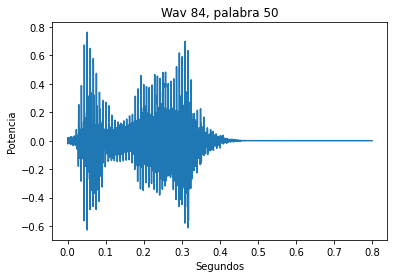

In [26]:
words_file = open("D:\\Decodificación del habla\\words_cutWordsAllExp_data.obj", "rb")
words_data = pickle.load(words_file)
words_file.close()

dt = 1/22050
almost_max_len = 0
wav_chooosed = 83
word_choosed = 49

choosed_word = words_data[wav_chooosed][word_choosed][2]
t_size = len(choosed_word)

x = np.arange(0, (t_size+1)*dt-dt, dt)
figure, axis = plt.subplots(1, 1)

axis.plot(x, choosed_word)
axis.set_title(f"Wav {wav_chooosed+1}, palabra {word_choosed+1}")
axis.set_xlabel("Segundos")
axis.set_ylabel("Potencia")

plt.show()

EXAMPLE. Run to reproduce the word of the prior graph

In [27]:
sd.play(words_data[wav_chooosed][word_choosed][2], 22050)
sd.wait()

EXAMPLE. Run to obtain a Mel Spectogram of the first word of the file

In [ ]:
test_signal = words_data[0][0][2]
test_mffcs = librosa.feature.mfcc(test_signal, n_mfcc=13, sr=22050)

plt.figure(figsize=(25,10))
librosa.display.specshow(test_mffcs, x_axis="time", sr=22050)
plt.colorbar(format="%+2f")

# print(test_mffcs)
print(len(test_mffcs[0])*13)

EXAMPLE. Run to get the first and second derivative and concatenate them in a single array

_Derivatives can be used to get more features about a single audio/word_

In [ ]:
test_delta_mffcs = librosa.feature.delta(test_mffcs)
test_delta2_mffcs = librosa.feature.delta(test_mffcs, order=2)

comprehensive_mfccs = np.concatenate((test_mffcs, test_delta_mffcs, test_delta2_mffcs))

***
# **Retrieving and saving all the mffc features from the cut words and their respectively objectives to separate files**

In [ ]:
all_exp_path = "D:\\Decodificación del habla\\"
exp_path = "D:\\Decodificación del habla\\Datos de palabras\\"

words_path = all_exp_path + "words_cutWordsAllExp_data.obj"
mffc_path = all_exp_path + "features_allMffc_data.obj"
target_path = all_exp_path + "target_allObjectives_data.obj"

all_file = open(words_path, "rb")
data = pickle.load(all_file)
all_file.close()

mffc_features_words = get_words_mffc(data, 22050, put_targets=False)
objectives_array = get_training_array(data)

all_features_file = open(mffc_path, "wb")
pickle.dump(mffc_features_words, all_features_file)
all_features_file.close()

all_targets_file = open(target_path, "wb")
pickle.dump(objectives_array, all_targets_file)
all_targets_file.close()

# **Retrieving and saving the features and their respective targets of each individual experiment**

In [ ]:
first_exp, last_exp = 11, 21

for exp in range(first_exp, last_exp+1):
    words_path = exp_path + "words_cutWordsS" + str(exp) + "_data.obj"
    mffc_path = exp_path + "features_mffcS" + str(exp) + "_data.obj"
    target_path = exp_path + "target_objectivesS" + str(exp) + "_data.obj"

    exp_file = open(words_path, "rb")
    exp_data = pickle.load(exp_file)
    exp_file.close()

    mffc_features_words = get_words_mffc(exp_data, 22050)
    objectives_array = get_training_array(exp_data)

    features_file = open(mffc_path, "wb")
    pickle.dump(mffc_features_words, features_file)
    features_file.close()

    training_array_file = open(target_path, "wb")
    pickle.dump(objectives_array, training_array_file)
    training_array_file.close()

***
# **Classification methods**

#### Retrieving the data from each experiment

In [19]:
path = "D:\\Decodificación del habla\\Datos de palabras\\"
mffc_exp = []
target_exp = []

for exp in range(1, len(experiments)+1):
    mffc_path = path + "features_mffcS" + str(exp) + "_data.obj"
    target_path = path + "target_objectivesS" + str(exp) + "_data.obj"

    features_file = open(mffc_path, "rb")
    mffc_exp.append(pickle.load(features_file))
    features_file.close()

    training_array_file = open(target_path, "rb")
    target_exp.append(pickle.load(training_array_file))
    training_array_file.close()

all_features_file = open("D:\\Decodificación del habla\\features_allMffc_data.obj", "rb")
all_mffc_features = pickle.load(all_features_file)
all_features_file.close()

all_targets_file = open("D:\\Decodificación del habla\\target_allObjectives_data.obj", "rb")
all_targets = pickle.load(all_targets_file)
all_targets_file.close()

## **Testing the classification models**

#### Using 4194 samples (from all experiments) divided into 5 different categories/words:

#### `{2: "Si", 3: "No", 4: "Agua", 5: "Comida", 6: "Dormir"}`

In [ ]:
print(f"With a matrix of shape ({len(all_mffc_features)}, {len(all_mffc_features[0])})\n")
get_model_scores(all_mffc_features, all_targets, model_type="linear")
print("")
# get_model_scores(all_mffc_features, all_targets, model_type="poly")
# print("")
get_model_scores(all_mffc_features, all_targets, model_type="rbf")
print("")
# get_model_scores(all_mffc_features, all_targets, model_type="sigmoid")
# print("")
get_model_scores(all_mffc_features, all_targets, model_type="tree")
print("")
get_model_scores(all_mffc_features, all_targets, model_type="knn")
print("")
get_model_scores(all_mffc_features, all_targets, model_type="neural_network")

#### Using 200 samples (1 experiment) on average divided into 5 different categories/words:

#### `{2: "Si", 3: "No", 4: "Agua", 5: "Comida", 6: "Dormir"}`

In [ ]:
for exp in range(len(mffc_exp)):
    print("------------------------------------------------------------------------------------------------------------------")
    print(f"S{exp+1} - Person number {exp+1}")
    print(f"With a matrix of shape ({len(mffc_exp[exp])}, {len(mffc_exp[exp][0])})\n")

    get_model_scores(mffc_exp[exp], target_exp[exp], model_type="linear")
    print("")
    get_model_scores(mffc_exp[exp], target_exp[exp], model_type="rbf")
    print("")
    get_model_scores(mffc_exp[exp], target_exp[exp], model_type="tree")
    print("")
    get_model_scores(mffc_exp[exp], target_exp[exp], model_type="knn")
    print("")
    get_model_scores(mffc_exp[exp], target_exp[exp], model_type="neural_network")

    print("\n")

***
# **Retrieving and saving the average mffc of each word _for all_ the experiments**

In [30]:
path = "D:\\Decodificación del habla\\features_allMffcTargets_data.obj"
words_path = "D:\\Decodificación del habla\\words_cutWordsAllExp_Data.obj"

avg_mffc_all = get_avg_mffc(path, experiments)

file = open("D:\\Decodificación del habla\\features_meanAllMffc_data.obj", "wb")
pickle.dump(avg_mffc_all, file)
file.close()

# **Retrieving and saving the average mffc of each word _for each_ experiment**

In [ ]:
path = "D:\\Decodificación del habla\\features_allMffcTargets_data.obj"
words_path = "D:\\Decodificación del habla\\words_cutWordsAllExp_Data.obj"

first_exp, last_exp = 11, 21
for exp in range(first_exp, last_exp+1):
    avg_mffc = get_avg_mffc(path, experiments, all_mffc=False, words_path=words_path, exp_n=exp+1)

    save_file = "D:\\Decodificación del habla\\Datos de palabras\\features_avgMffcS" + str(exp+1) + "_data.obj"
    file = open(save_file, "wb")
    pickle.dump(avg_mffc, file)
    file.close()

# **Plotting the average mffc _for all_ the experiments and _for each_ experiment**

In [ ]:
all_avg_path = "D:\\Decodificación del habla\\features_meanAllMffc_data.obj"
ind_avg_path = "D:\\Decodificación del habla\\Datos de palabras\\features_avgMffcS"

plot_mffc_spectograms(all_avg_path, "Average mffc for all experiments", limit_colorbar=True)

for exp in range(len(experiments)):
    path = ind_avg_path + str(exp+1) + "_data.obj"
    title = "Average mffc for exp S" + str(exp+1)
    plot_mffc_spectograms(path, title, limit_colorbar=True)